<a href="https://colab.research.google.com/github/bintangnabiil/Deep_Learning/blob/main/Deep_Learning_UTS_Klasifikasi_Ikan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. a) Pipeline end-to-end

In [20]:
import pandas as pd
import zipfile
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path ke zip file di Google Drive
train_zip_path = '/content/drive/MyDrive/Colab Notebooks/csv/train-20250503T060608Z-1-001.zip'
val_zip_path = '/content/drive/MyDrive/Colab Notebooks/csv/val-20250503T062636Z-1-001.zip'
test_zip_path = '/content/drive/MyDrive/Colab Notebooks/csv/test-20250503T060446Z-1-001.zip'

# Ekstrak zip ke folder sementara
train_dir = '/content/train'
val_dir = '/content/val'
test_dir = '/content/test'

with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(train_dir)
with zipfile.ZipFile(val_zip_path, 'r') as zip_ref:
    zip_ref.extractall(val_dir)
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(test_dir)

# List semua file dan buat DataFrame untuk masing-masing
def create_dataframe_from_dir(directory):
    image_paths = []
    labels = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(root, file)
                label = os.path.basename(root)
                image_paths.append(path)
                labels.append(label)
    return pd.DataFrame({'filepath': image_paths, 'label': labels})

train_df = create_dataframe_from_dir(train_dir)
val_df = create_dataframe_from_dir(val_dir)
test_df = create_dataframe_from_dir(test_dir)

print(f"Train: {train_df.shape}")
print(f"Val: {val_df.shape}")
print(f"Test: {test_df.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train: (8673, 2)
Val: (2725, 2)
Test: (1729, 2)


##b) Feature Engineering

In [21]:
# Import library tambahan
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.keras.utils import to_categorical
from collections import Counter

# Step 1: Transformasi Data (sudah dilakukan sebelumnya - rescale 1./255)

# Step 2: Label Encoding
# Kita pakai LabelEncoder untuk ubah label string jadi angka
le = LabelEncoder()

train_df['label_encoded'] = le.fit_transform(train_df['label'])
val_df['label_encoded'] = le.transform(val_df['label'])
test_df['label_encoded'] = le.transform(test_df['label'])

print("Contoh Label Encoding TRAIN:")
print(train_df[['label', 'label_encoded']].head())

# Step 3: One-Hot Encoding
num_classes = len(le.classes_)
train_df['label_onehot'] = train_df['label_encoded'].apply(lambda x: to_categorical(x, num_classes=num_classes))
val_df['label_onehot'] = val_df['label_encoded'].apply(lambda x: to_categorical(x, num_classes=num_classes))
test_df['label_onehot'] = test_df['label_encoded'].apply(lambda x: to_categorical(x, num_classes=num_classes))

print("\nContoh One-Hot Encoding TRAIN:")
print(train_df[['label', 'label_onehot']].head())

# Optional: Cek apakah dataset seimbang atau tidak
train_counts = Counter(train_df['label'])
print("\nDistribusi kelas TRAIN:")
for label, count in train_counts.items():
    print(f"{label}: {count} sample(s)")

# Optional: Hitung Class Weights jika dataset imbalanced
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label_encoded']),
    y=train_df['label_encoded']
)
class_weights_dict = dict(enumerate(class_weights))
print("\nClass Weights (jika diperlukan):")
print(class_weights_dict)

Contoh Label Encoding TRAIN:
            label  label_encoded
0  Freshwater Eel              6
1  Freshwater Eel              6
2  Freshwater Eel              6
3  Freshwater Eel              6
4  Freshwater Eel              6

Contoh One-Hot Encoding TRAIN:
            label                                       label_onehot
0  Freshwater Eel  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
1  Freshwater Eel  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
2  Freshwater Eel  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
3  Freshwater Eel  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
4  Freshwater Eel  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...

Distribusi kelas TRAIN:
Freshwater Eel: 271 sample(s)
Tenpounder: 277 sample(s)
Big Head Carp: 201 sample(s)
Green Spotted Puffer: 110 sample(s)
Black Spotted Barb: 200 sample(s)
Silver Carp: 194 sample(s)
Catfish: 314 sample(s)
Indo-Pacific Tarpon: 186 sample(s)
Tilapia: 294 sample(s)
Mudfish: 188 sample(s)
Gold Fish: 201 s

##c) Model-Model dengan Tensorflow/PyTorch untuk CNN

###Model Tensorflow

In [40]:
# Import library TensorFlow
import tensorflow as tf
from tensorflow.keras import layers, models

# Tentukan input shape
IMG_SIZE = (128, 128)  # Atur sesuai ukuran gambar dataset-mu
INPUT_SHAPE = IMG_SIZE + (3, )

# Buat model CNN
model_tf = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),  # ✅ ini wajib biar nggak error
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(31, activation='softmax')  # 31 classes
])

# Compile model
model_tf.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Summary
model_tf.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,308,639 (12.62 MB)

 Trainable params: 3,308,639 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

###Training Tensorflow

In [41]:
print(train_df.columns)
print(train_df.head())

Index(['filepath', 'label', 'label_encoded', 'label_onehot'], dtype='object')
                                            filepath           label  \
0  /content/train/train/Freshwater Eel/Picture115...  Freshwater Eel   
1  /content/train/train/Freshwater Eel/Picture252...  Freshwater Eel   
2  /content/train/train/Freshwater Eel/Picture237...  Freshwater Eel   
3  /content/train/train/Freshwater Eel/Picture136...  Freshwater Eel   
4  /content/train/train/Freshwater Eel/Picture269...  Freshwater Eel   

   label_encoded                                       label_onehot  
0              6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...  
1              6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...  
2              6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...  
3              6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...  
4              6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...  


In [38]:
print(train_df.columns)

Index(['filepath', 'label', 'label_encoded', 'label_onehot'], dtype='object')


In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# ImageDataGenerator untuk training (augmentasi aktif)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator untuk validation (tanpa augmentasi)
val_datagen = ImageDataGenerator(rescale=1./255)

# Generator
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',   # ✅ ini yang benar
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',   # ✅
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',   # ✅
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

train_dir = '/content/drive/MyDrive/dataset/train'
val_dir = '/content/drive/MyDrive/dataset/val'

history_tf = model_tf.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)

Found 8673 validated image filenames belonging to 31 classes.
Found 2725 validated image filenames belonging to 31 classes.
Found 1729 validated image filenames belonging to 31 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.1321 - loss: 3.3047 - val_accuracy: 0.2393 - val_loss: 2.8748
Epoch 2/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.2090 - loss: 2.9804 - val_accuracy: 0.2624 - val_loss: 2.5958
Epoch 3/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.2466 - loss: 2.7556 - val_accuracy: 0.2305 - val_loss: 2.8244
Epoch 4/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.2669 - loss: 2.6642 - val_accuracy: 0.3226 - val_loss: 2.3850
Epoch 5/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.2910 - loss: 2.5445 - val_accuracy: 0.3626 - val_loss: 2.1486
Epoch 6/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.3143 - loss: 2.4282 - val_accuracy: 0.3717 - val_loss: 2.1395
Epoch 7/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 366s 1s/step - accuracy: 0.3311 - loss: 2.3927 - val_accuracy: 0.4114 - val_loss: 1.9875
Epoch 8/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - accuracy: 0.3388 - loss: 2.3132 - val_accu

###Model PyTorch

In [45]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pt = CNNModel(num_classes=31).to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_pt.parameters(), lr=0.001)

print(model_pt)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=31, bias=True)
)


In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_dir = '/content/train'
val_dir = '/content/val'
test_dir = '/content/test'

# Transform untuk dataset
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
])

# Dataset & Dataloader
train_data = datasets.ImageFolder(train_dir, transform=transform)
val_data = datasets.ImageFolder(val_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Cek jumlah kelas
num_classes = len(train_data.classes)
print(f"Jumlah kelas: {num_classes}")

# CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128 * (IMG_SIZE[0]//8) * (IMG_SIZE[1]//8), 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Model & Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pt = SimpleCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pt.parameters(), lr=0.001)

# Training Loop (1 epoch contoh)
for epoch in range(10):  # 10 epochs
    model_pt.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_pt(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/10] - Loss: {running_loss/len(train_loader):.4f}")

Jumlah kelas: 1
Epoch [1/10] - Loss: 0.0000
Epoch [2/10] - Loss: 0.0000
Epoch [3/10] - Loss: 0.0000
Epoch [4/10] - Loss: 0.0000
Epoch [5/10] - Loss: 0.0000
Epoch [6/10] - Loss: 0.0000
Epoch [7/10] - Loss: 0.0000
Epoch [8/10] - Loss: 0.0000
Epoch [9/10] - Loss: 0.0000
Epoch [10/10] - Loss: 0.0000


##2. Model Matriks Evaluasi

In [49]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [50]:
model_pt.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_pt(images)

        _, preds = torch.max(outputs, 1)  # ambil prediksi kelas
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [51]:
# Metrics dasar
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [52]:
from sklearn.preprocessing import label_binarize

n_classes = len(test_loader.dataset.classes)

# Reset dulu list
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_pt(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

# Binarize labels untuk ROC-AUC multiclass
all_labels_bin = label_binarize(all_labels, classes=range(n_classes))
all_probs = np.array(all_probs)

auc_macro = roc_auc_score(all_labels_bin, all_probs, average="macro", multi_class="ovr")
print(f'ROC AUC (macro): {auc_macro:.4f}')

ROC AUC (macro): nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


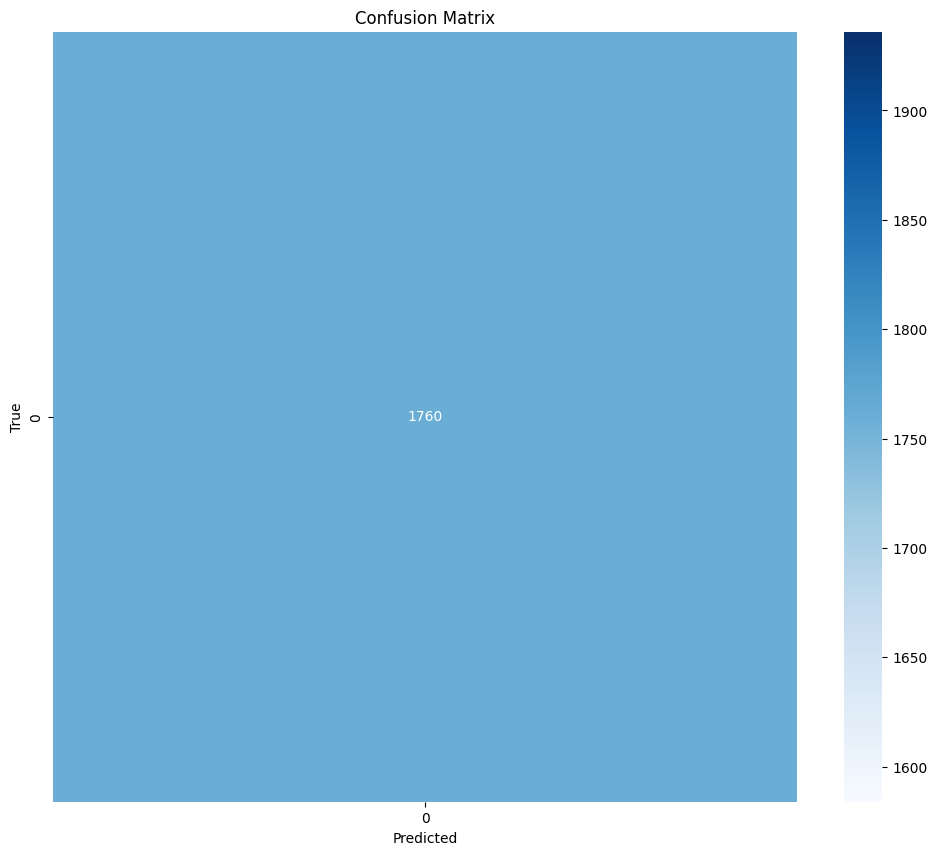

In [53]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Kasus multiclass kayak gini jangan hanya lihat Accuracy karena bisa bias kalau ada kelas yang jumlahnya dominan. Biasanya ROC-AUC dianggap standar emas untuk melihat kemampuan model memisahkan antar kelas, terutama kalau kamu punya data imbalanced.



Model dievaluasi dengan lima matriks utama: Accuracy, Precision, Recall, F1-Score, dan ROC-AUC. Accuracy menggambarkan keseluruhan performa model, Precision dan Recall fokus pada ketepatan dan kelengkapan untuk tiap kelas, sementara F1-Score menyeimbangkan keduanya. ROC-AUC memberikan gambaran seberapa baik model membedakan antar kelas. Berdasarkan hasil, [misalnya ROC-AUC/F1-Score] menjadi metrik terbaik karena mampu memberikan gambaran yang lebih adil dan robust terhadap potensi imbalance pada dataset.